In [1]:
import codigo
from codigo import utils
from codigo import model_LSTM
from codigo import model_utils
from cg_ega.cg_ega import CG_EGA

In [2]:
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment',None)
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
modeloBasePath='modelos/modeloGeneral/vanilla_dropout.h5'
modeloSave='/transfer_vanilla_dropout.h5'

In [19]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

# Paciente Q1

In [5]:
paciente='paciente1'

In [6]:
with open('dataset/generado/'+paciente+'/array_Xtrain.npy', 'rb') as f:
    array_Xtrain = np.load(f)

In [7]:
len(array_Xtrain)

1523

In [8]:
with open('dataset/generado/'+paciente+'/array_Ytrain.npy', 'rb') as f:
    array_Ytrain = np.load(f)

In [9]:
len(array_Ytrain)

1523

In [10]:
with open('dataset/generado/'+paciente+'/array_Xval.npy', 'rb') as f:
    array_Xval = np.load(f)

In [11]:
len(array_Xval)

190

In [12]:
with open('dataset/generado/'+paciente+'/array_Yval.npy', 'rb') as f:
    array_Yval = np.load(f)

In [13]:
len(array_Yval)

190

In [14]:
with open('dataset/generado/'+paciente+'/array_Xtest.npy', 'rb') as f:
    array_Xtest = np.load(f)

In [15]:
len(array_Xtest)

191

In [16]:
with open('dataset/generado/'+paciente+'/array_Ytest.npy', 'rb') as f:
    array_Ytest = np.load(f)

In [17]:
len(array_Ytest)

191

In [18]:
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', patience=3, min_delta=0.001)

# Rendimiento del Modelo base

In [20]:
base_model = keras.models.load_model(modeloBasePath)

6/6 [==============================] - 0s 6ms/step


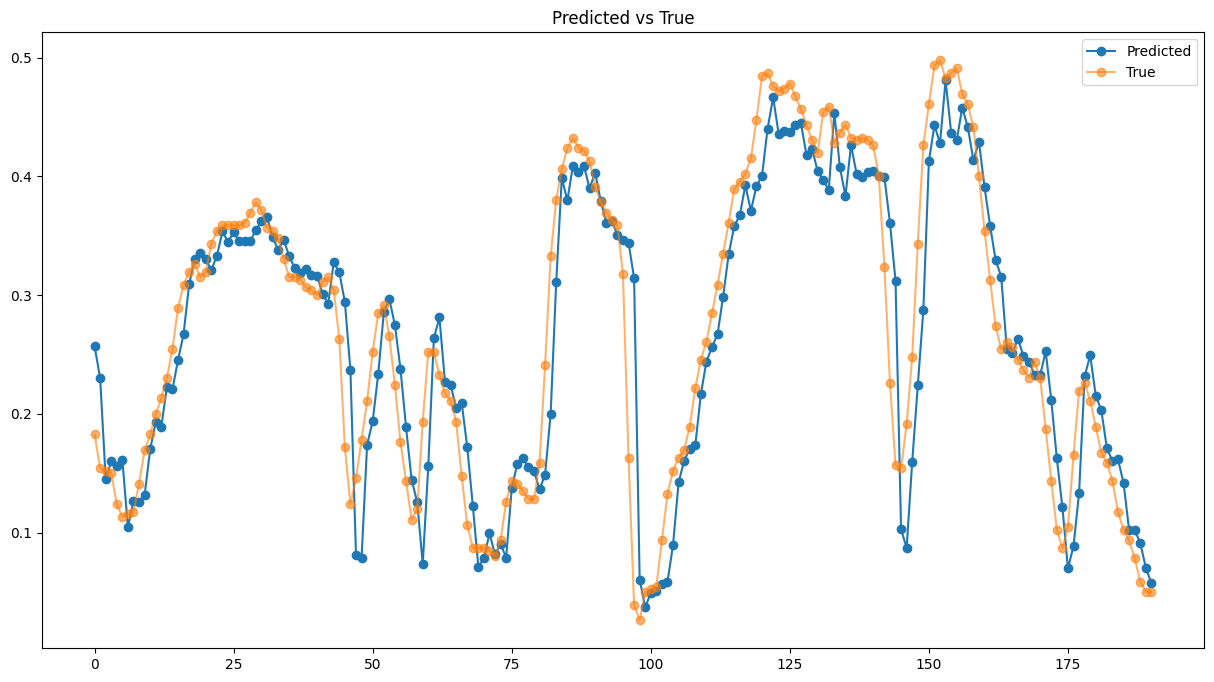

In [21]:
yhat = base_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [22]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.03631403151294948,
 'mse': 0.05150329549445391,
 'rmse': 0.0026525894467890367}

# Iniciamos transfer learning

In [23]:
# Freeze the base_model
base_model.trainable = False

In [24]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [25]:
x = base_model.layers[-2].output 

x = tf.keras.layers.Dense(16, activation='relu',name='newLayer')(x) 
predictions = tf.keras.layers.Dense(1,name='output')(x) 
    
finetune_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [26]:
base_model.layers[-2].output

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dropout_2')>

In [27]:
finetune_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 5)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

In [28]:
finetune_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae','mse'])

history =finetune_model.fit(array_Xtrain, array_Ytrain,epochs=epochs, validation_data=(array_Xval, array_Yval), shuffle=False, callbacks=[early_stopping])
finetune_model.save('modelos/'+paciente+modeloSave)

Epoch 1/100
48/48 [==============================] - 2s 15ms/step - loss: 0.0154 - mae: 0.1009 - mse: 0.0154 - val_loss: 0.0065 - val_mae: 0.0663 - val_mse: 0.0065
Epoch 2/100
48/48 [==============================] - 0s 9ms/step - loss: 0.0070 - mae: 0.0637 - mse: 0.0070 - val_loss: 0.0034 - val_mae: 0.0446 - val_mse: 0.0034
Epoch 3/100
48/48 [==============================] - 0s 8ms/step - loss: 0.0053 - mae: 0.0545 - mse: 0.0053 - val_loss: 0.0029 - val_mae: 0.0389 - val_mse: 0.0029
Epoch 4/100
48/48 [==============================] - 0s 8ms/step - loss: 0.0044 - mae: 0.0498 - mse: 0.0044 - val_loss: 0.0028 - val_mae: 0.0388 - val_mse: 0.0028
Epoch 5/100
48/48 [==============================] - 0s 8ms/step - loss: 0.0043 - mae: 0.0494 - mse: 0.0043 - val_loss: 0.0032 - val_mae: 0.0421 - val_mse: 0.0032
Epoch 6/100
48/48 [==============================] - 0s 8ms/step - loss: 0.0040 - mae: 0.0478 - mse: 0.0040 - val_loss: 0.0028 - val_mae: 0.0397 - val_mse: 0.0028


6/6 [==============================] - 0s 6ms/step - loss: 0.0043 - mae: 0.0548 - mse: 0.0043
test loss, test acc: [0.00429509487003088, 0.05477149784564972, 0.00429509487003088]


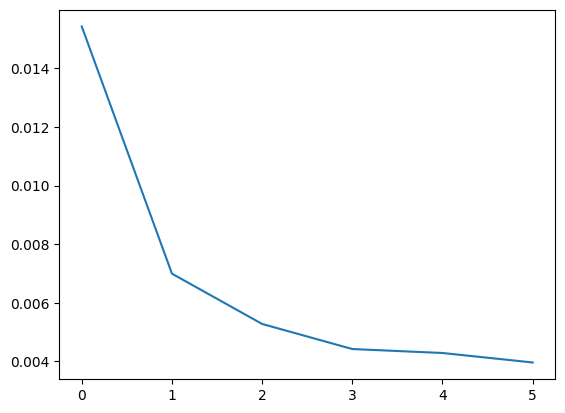

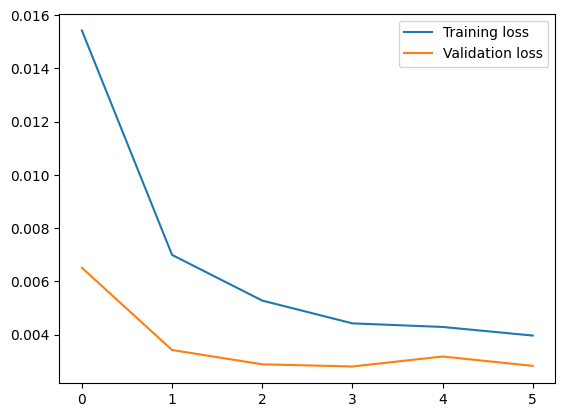

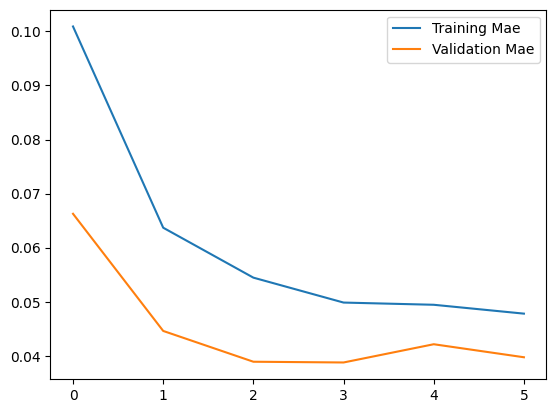

In [29]:
model_utils.modelEvaluateTraining(finetune_model,history,array_Xtest, array_Ytest)

6/6 [==============================] - 0s 6ms/step


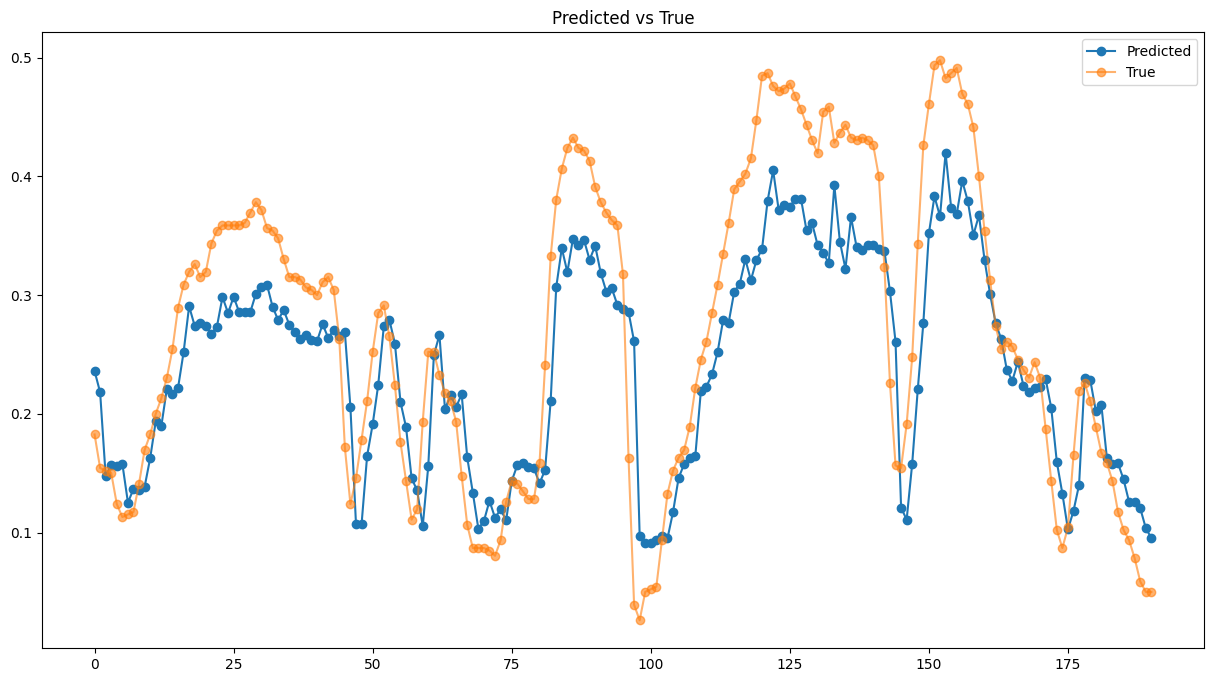

In [30]:
yhat = finetune_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [31]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.054771503831554366,
 'mse': 0.06553697926387589,
 'rmse': 0.004295095651033698}

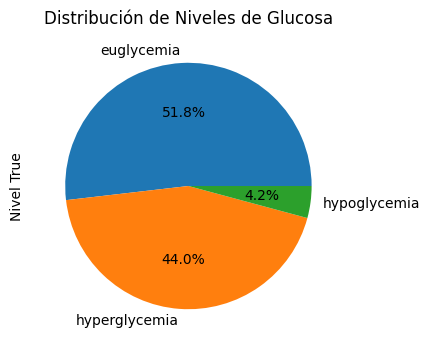

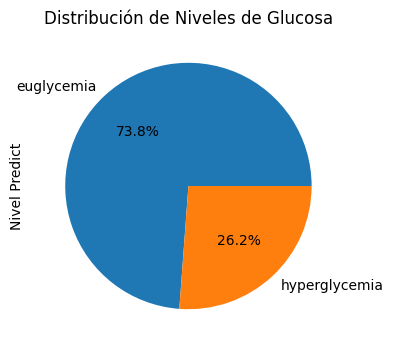

Glucose level True  Nivel True  Glucose level Predict Nivel Predict
0               124.0  euglycemia             148.599533    euglycemia
1               111.0  euglycemia             140.344696    euglycemia
2               110.0  euglycemia             107.793213    euglycemia
3               109.0  euglycemia             112.359550    euglycemia
4                97.0  euglycemia             111.720863    euglycemia

In [32]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


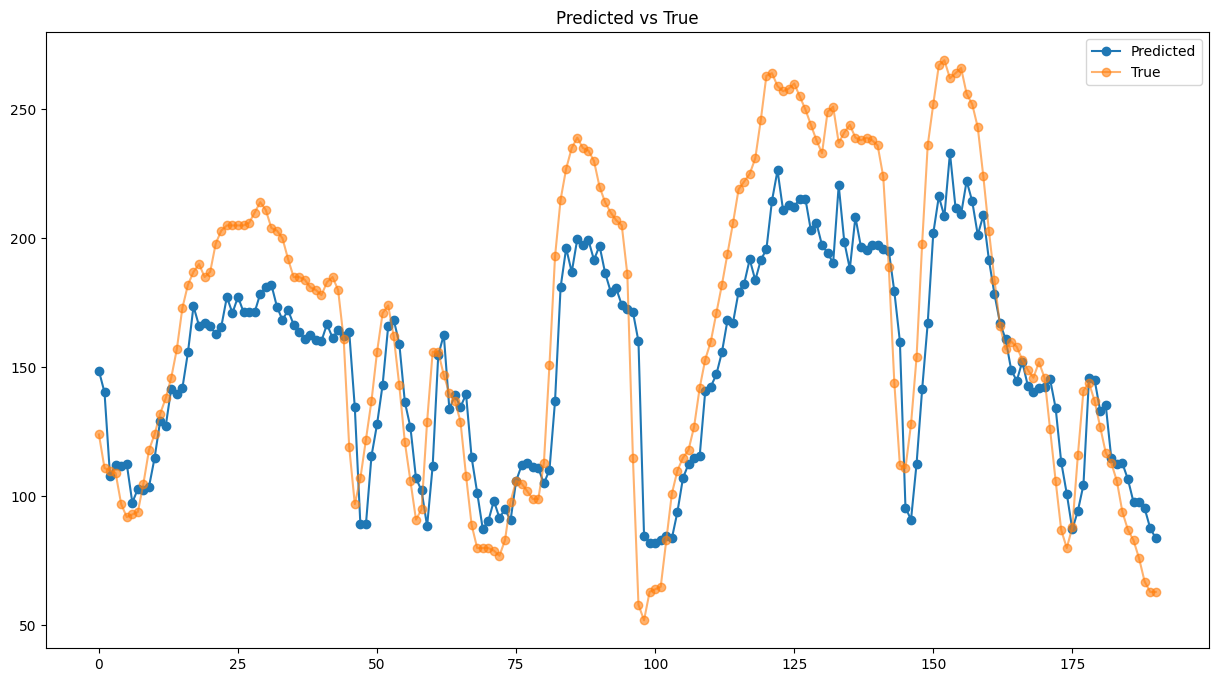

{'mae': 25.194889807576285, 'mse': 30.1470084185205, 'rmse': 908.8421165863459}

In [33]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [34]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=df_glucose['Glucose level True']
dfPlot['y_pred']=df_glucose['Glucose level Predict']
dfPlot.index=pd.date_range("2023-01-01", periods=len(df_glucose['Glucose level True']), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   124.0  148.599533
2023-01-01 00:15:00   111.0  140.344696
2023-01-01 00:30:00   110.0  107.793213
2023-01-01 00:45:00   109.0  112.359550
2023-01-01 01:00:00    97.0  111.720863
...                     ...         ...
2023-01-02 22:30:00    83.0   97.784782
2023-01-02 22:45:00    76.0   97.992226
2023-01-02 23:00:00    67.0   95.394814
2023-01-02 23:15:00    63.0   87.680443
2023-01-02 23:30:00    63.0   83.821411

[191 rows x 2 columns]

AP, BE, EP: (0.8947368421052632, 0.06315789473684211, 0.042105263157894736)


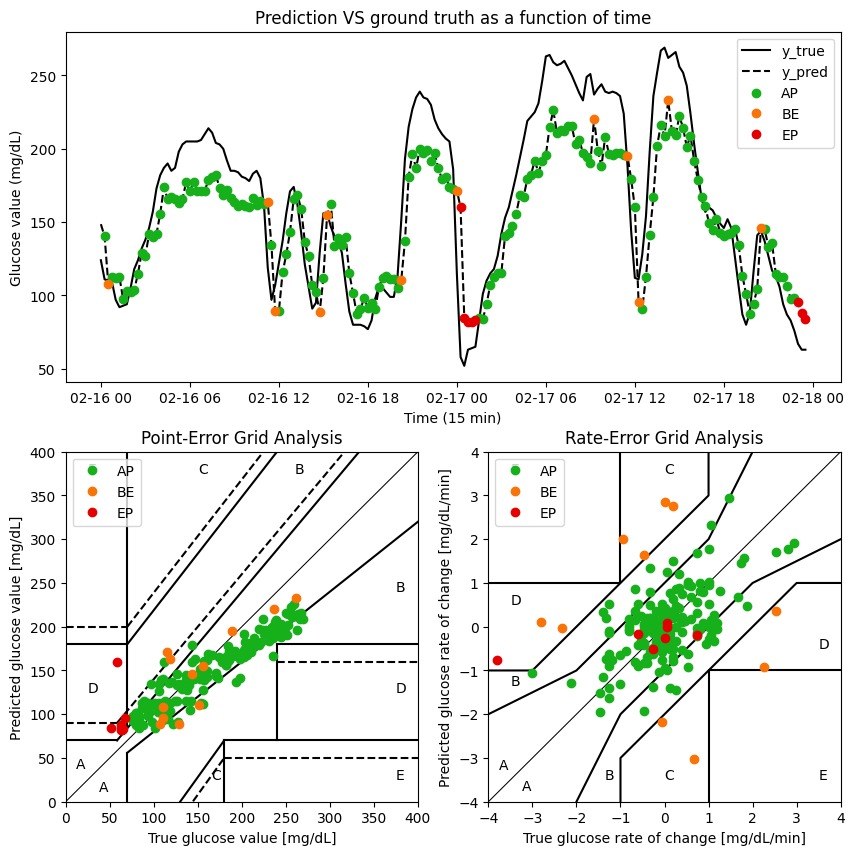

In [35]:
freq = 15
cg_ega = CG_EGA(dfPlot, freq)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

# Paciente Q2

In [36]:
paciente='paciente2'

In [37]:
with open('dataset/generado/'+paciente+'/array_Xtrain.npy', 'rb') as f:
    array_Xtrain = np.load(f)

In [38]:
len(array_Xtrain)

13931

In [39]:
with open('dataset/generado/'+paciente+'/array_Ytrain.npy', 'rb') as f:
    array_Ytrain = np.load(f)

In [40]:
len(array_Ytrain)

13931

In [41]:
with open('dataset/generado/'+paciente+'/array_Xval.npy', 'rb') as f:
    array_Xval = np.load(f)

In [42]:
len(array_Xval)

1741

In [43]:
with open('dataset/generado/'+paciente+'/array_Yval.npy', 'rb') as f:
    array_Yval = np.load(f)

In [44]:
len(array_Yval)

1741

In [45]:
with open('dataset/generado/'+paciente+'/array_Xtest.npy', 'rb') as f:
    array_Xtest = np.load(f)

In [46]:
len(array_Xtest)

1742

In [47]:
with open('dataset/generado/'+paciente+'/array_Ytest.npy', 'rb') as f:
    array_Ytest = np.load(f)

In [48]:
len(array_Ytest)

1742

In [49]:
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', patience=3, min_delta=0.001)

# Rendimiento del Modelo base

In [50]:
base_model = keras.models.load_model(modeloBasePath)

55/55 [==============================] - 0s 5ms/step


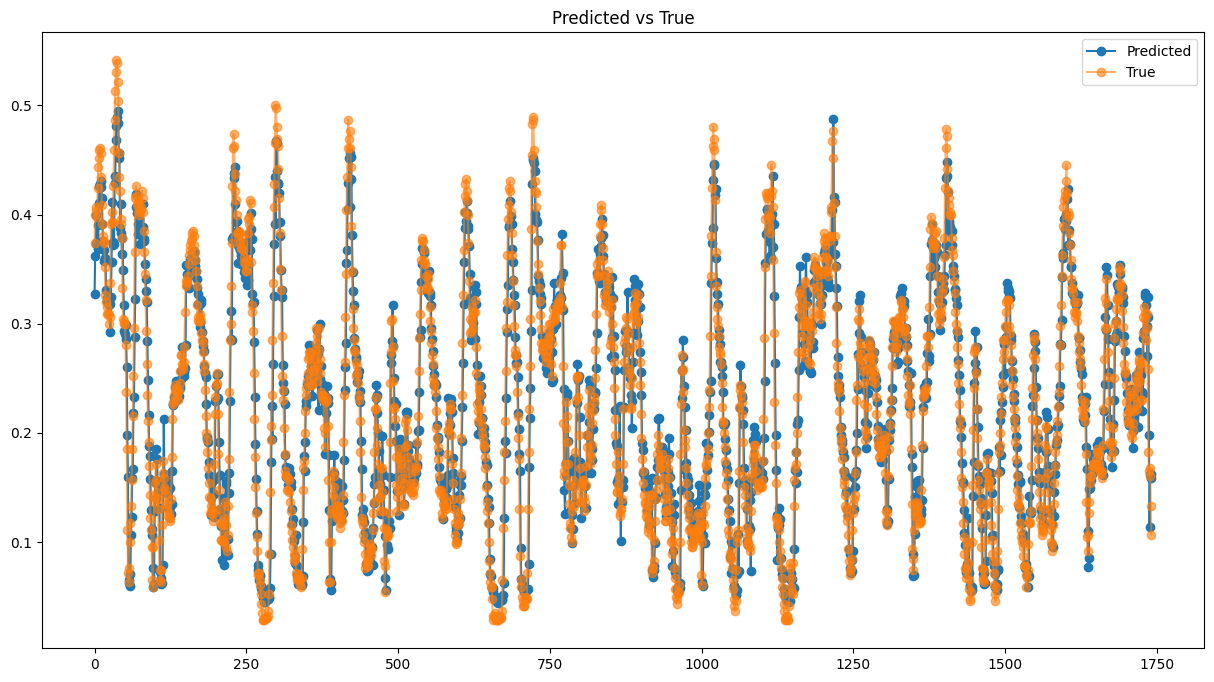

In [51]:
yhat = base_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [52]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.022967179749626455,
 'mse': 0.02998608648691033,
 'rmse': 0.0008991653828004663}

# Iniciamos transfer learning

In [53]:
# Freeze the base_model
base_model.trainable = False

In [54]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [55]:
x = base_model.layers[-2].output 

x = tf.keras.layers.Dense(16, activation='relu',name='newLayer')(x) 
predictions = tf.keras.layers.Dense(1,name='output')(x) 
    
finetune_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [56]:
base_model.layers[-2].output

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dropout_2')>

In [57]:
finetune_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 5)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0   

In [58]:
finetune_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae','mse'])

history =finetune_model.fit(array_Xtrain, array_Ytrain,epochs=epochs, validation_data=(array_Xval, array_Yval), shuffle=False, callbacks=[early_stopping])
finetune_model.save('modelos/'+paciente+modeloSave)

Epoch 1/100
436/436 [==============================] - 4s 8ms/step - loss: 0.0049 - mae: 0.0437 - mse: 0.0049 - val_loss: 0.0015 - val_mae: 0.0293 - val_mse: 0.0015
Epoch 2/100
436/436 [==============================] - 3s 7ms/step - loss: 0.0011 - mae: 0.0234 - mse: 0.0011 - val_loss: 0.0011 - val_mae: 0.0251 - val_mse: 0.0011
Epoch 3/100
436/436 [==============================] - 3s 7ms/step - loss: 8.7743e-04 - mae: 0.0210 - mse: 8.7743e-04 - val_loss: 0.0010 - val_mae: 0.0248 - val_mse: 0.0010
Epoch 4/100
436/436 [==============================] - 3s 6ms/step - loss: 7.9293e-04 - mae: 0.0198 - mse: 7.9293e-04 - val_loss: 9.1838e-04 - val_mae: 0.0230 - val_mse: 9.1838e-04
Epoch 5/100
436/436 [==============================] - 3s 6ms/step - loss: 7.5654e-04 - mae: 0.0193 - mse: 7.5654e-04 - val_loss: 8.9044e-04 - val_mae: 0.0229 - val_mse: 8.9044e-04
Epoch 6/100
436/436 [==============================] - 3s 6ms/step - loss: 7.4776e-04 - mae: 0.0192 - mse: 7.4776e-04 - val_loss: 9.174

55/55 [==============================] - 0s 5ms/step - loss: 0.0010 - mae: 0.0248 - mse: 0.0010
test loss, test acc: [0.0010392636759206653, 0.024799887090921402, 0.0010392636759206653]


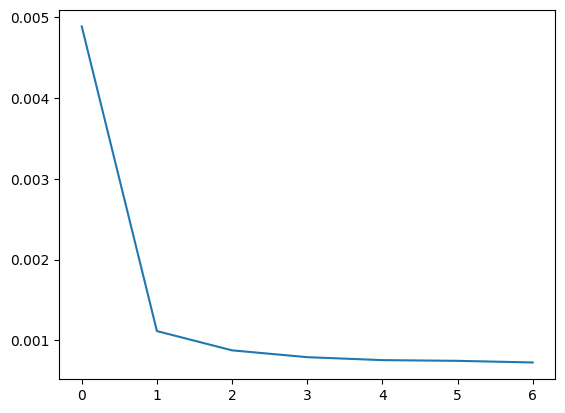

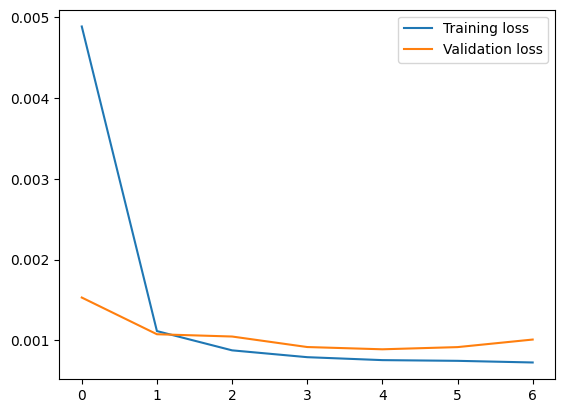

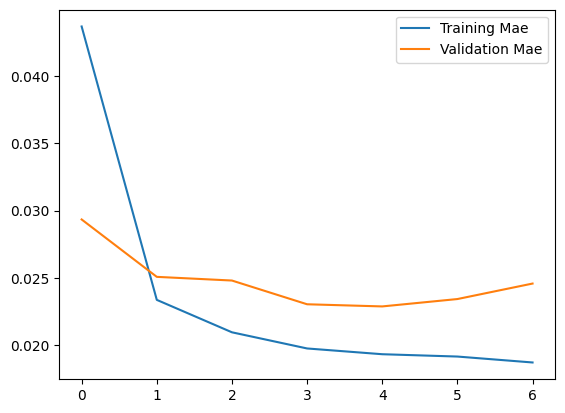

In [59]:
model_utils.modelEvaluateTraining(finetune_model,history,array_Xtest, array_Ytest)

55/55 [==============================] - 0s 4ms/step


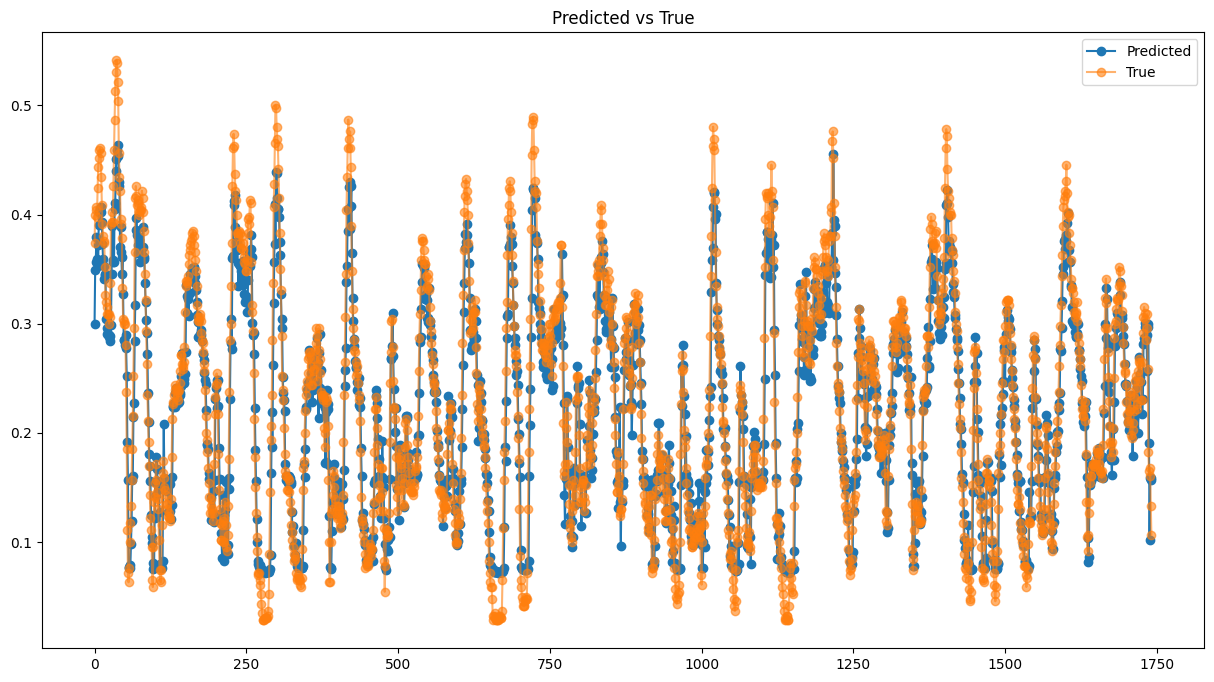

In [60]:
yhat = finetune_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [61]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.024799887556437954,
 'mse': 0.032237611890157024,
 'rmse': 0.0010392636203803937}

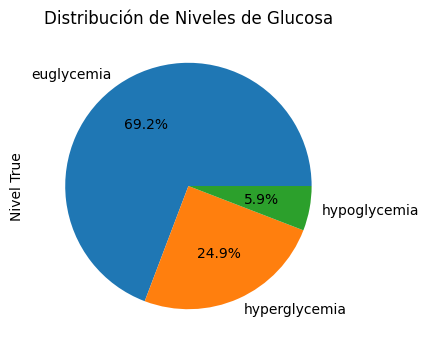

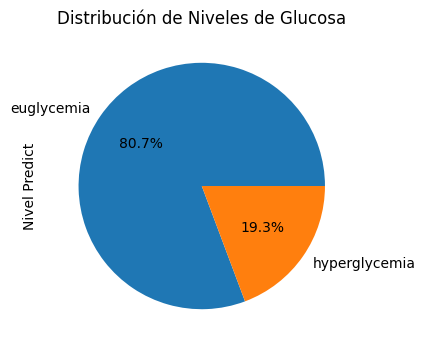

Glucose level True     Nivel True  Glucose level Predict  Nivel Predict
0               212.0  hyperglycemia             178.042938     euglycemia
1               224.0  hyperglycemia             200.523422  hyperglycemia
2               226.0  hyperglycemia             204.152115  hyperglycemia
3               227.0  hyperglycemia             214.661453  hyperglycemia
4               223.0  hyperglycemia             205.045609  hyperglycemia

In [62]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


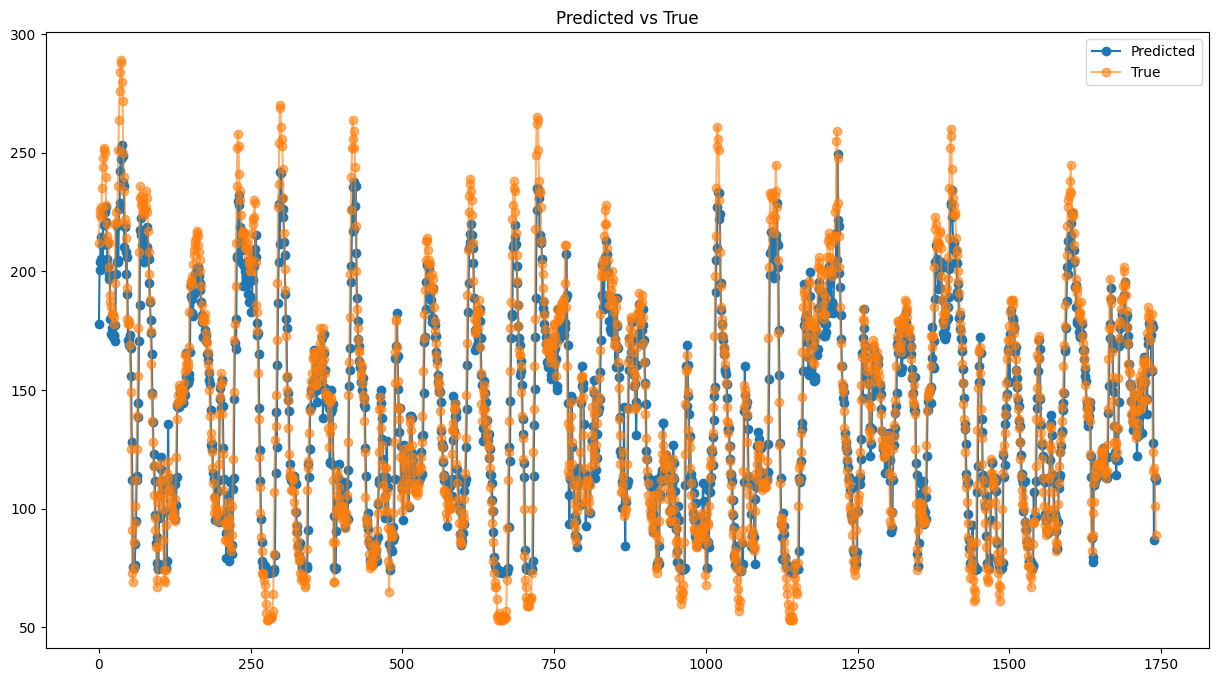

{'mae': 11.40794748217951,
 'mse': 14.829300512066448,
 'rmse': 219.9081536771742}

In [63]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [64]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=df_glucose['Glucose level True']
dfPlot['y_pred']=df_glucose['Glucose level Predict']
dfPlot.index=pd.date_range("2023-01-01", periods=len(df_glucose['Glucose level True']), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   212.0  178.042938
2023-01-01 00:15:00   224.0  200.523422
2023-01-01 00:30:00   226.0  204.152115
2023-01-01 00:45:00   227.0  214.661453
2023-01-01 01:00:00   223.0  205.045609
...                     ...         ...
2023-01-19 02:15:00   116.0  127.633690
2023-01-19 02:30:00   117.0   86.878181
2023-01-19 02:45:00   114.0  112.828087
2023-01-19 03:00:00   101.0  112.760132
2023-01-19 03:15:00    89.0  112.042755

[1742 rows x 2 columns]

AP, BE, EP: (0.9437105112004595, 0.019529006318207927, 0.03676048248133257)


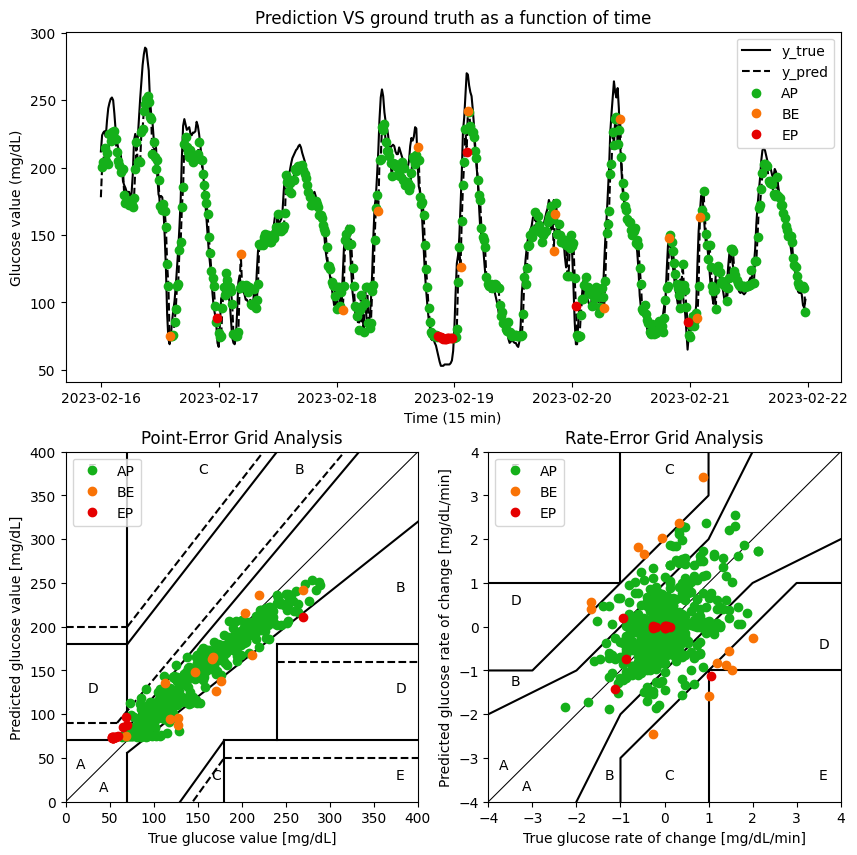

In [65]:
freq = 15
cg_ega = CG_EGA(dfPlot, freq)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

# Paciente Q3

In [66]:
paciente='paciente3'

In [67]:
with open('dataset/generado/'+paciente+'/array_Xtrain.npy', 'rb') as f:
    array_Xtrain = np.load(f)

In [68]:
len(array_Xtrain)

28683

In [69]:
with open('dataset/generado/'+paciente+'/array_Ytrain.npy', 'rb') as f:
    array_Ytrain = np.load(f)

In [70]:
len(array_Ytrain)

28683

In [71]:
with open('dataset/generado/'+paciente+'/array_Xval.npy', 'rb') as f:
    array_Xval = np.load(f)

In [72]:
len(array_Xval)

3585

In [73]:
with open('dataset/generado/'+paciente+'/array_Yval.npy', 'rb') as f:
    array_Yval = np.load(f)

In [74]:
len(array_Yval)

3585

In [75]:
with open('dataset/generado/'+paciente+'/array_Xtest.npy', 'rb') as f:
    array_Xtest = np.load(f)

In [76]:
len(array_Xtest)

3586

In [77]:
with open('dataset/generado/'+paciente+'/array_Ytest.npy', 'rb') as f:
    array_Ytest = np.load(f)

In [78]:
len(array_Ytest)

3586

In [79]:
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', patience=3, min_delta=0.001)

# Rendimiento del Modelo base

In [80]:
base_model = keras.models.load_model(modeloBasePath)

113/113 [==============================] - 1s 5ms/step


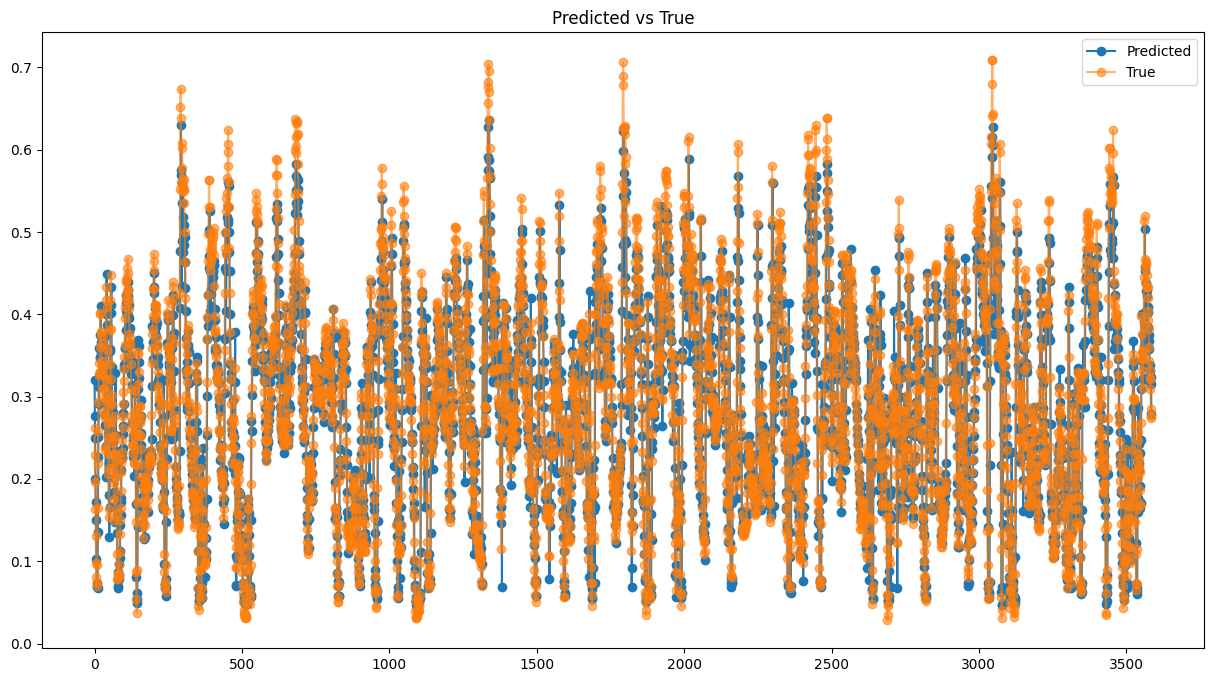

In [81]:
yhat = base_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [82]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.03608565697043894,
 'mse': 0.050227034452233046,
 'rmse': 0.002522754989865805}

# Iniciamos transfer learning

In [83]:
# Freeze the base_model
base_model.trainable = False

In [84]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [85]:
x = base_model.layers[-2].output 

x = tf.keras.layers.Dense(16, activation='relu',name='newLayer')(x) 
predictions = tf.keras.layers.Dense(1,name='output')(x) 
    
finetune_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [86]:
base_model.layers[-2].output

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dropout_2')>

In [87]:
finetune_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 5)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0   

In [88]:
finetune_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae','mse'])

history =finetune_model.fit(array_Xtrain, array_Ytrain,epochs=epochs, validation_data=(array_Xval, array_Yval), shuffle=False, callbacks=[early_stopping])
finetune_model.save('modelos/'+paciente+modeloSave)

Epoch 1/100
897/897 [==============================] - 8s 7ms/step - loss: 0.0057 - mae: 0.0539 - mse: 0.0057 - val_loss: 0.0031 - val_mae: 0.0414 - val_mse: 0.0031
Epoch 2/100
897/897 [==============================] - 7s 7ms/step - loss: 0.0037 - mae: 0.0443 - mse: 0.0037 - val_loss: 0.0034 - val_mae: 0.0437 - val_mse: 0.0034
Epoch 3/100
897/897 [==============================] - 7s 8ms/step - loss: 0.0035 - mae: 0.0432 - mse: 0.0035 - val_loss: 0.0033 - val_mae: 0.0426 - val_mse: 0.0033
Epoch 4/100
897/897 [==============================] - 7s 8ms/step - loss: 0.0034 - mae: 0.0429 - mse: 0.0034 - val_loss: 0.0034 - val_mae: 0.0434 - val_mse: 0.0034


113/113 [==============================] - 1s 5ms/step - loss: 0.0036 - mae: 0.0445 - mse: 0.0036
test loss, test acc: [0.0036179558373987675, 0.04454003646969795, 0.0036179558373987675]


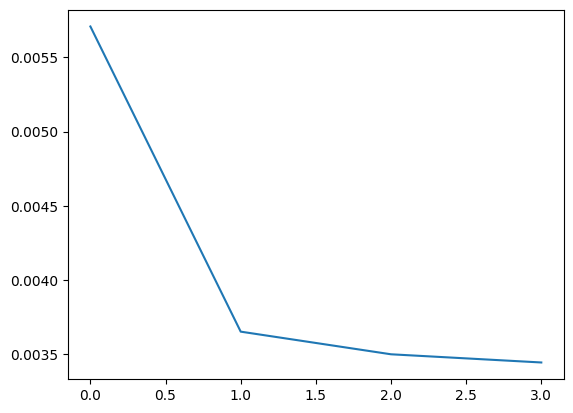

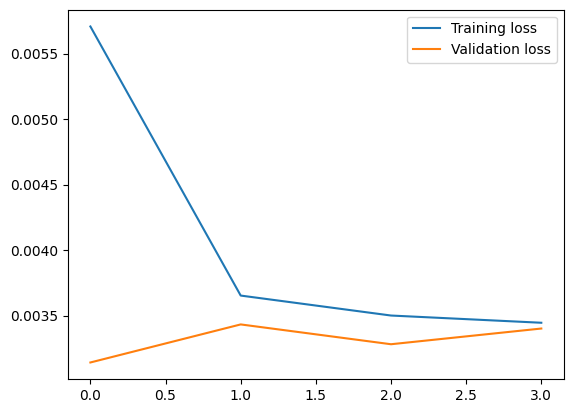

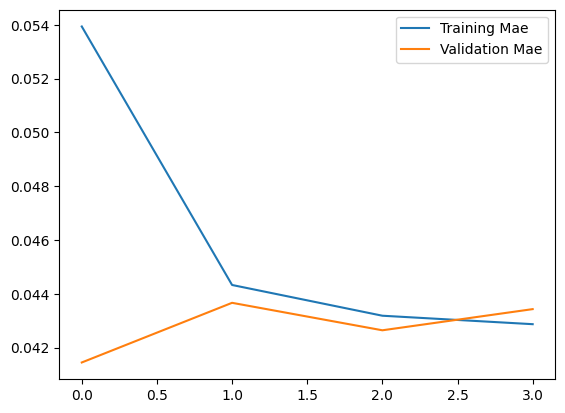

In [89]:
model_utils.modelEvaluateTraining(finetune_model,history,array_Xtest, array_Ytest)

113/113 [==============================] - 1s 5ms/step


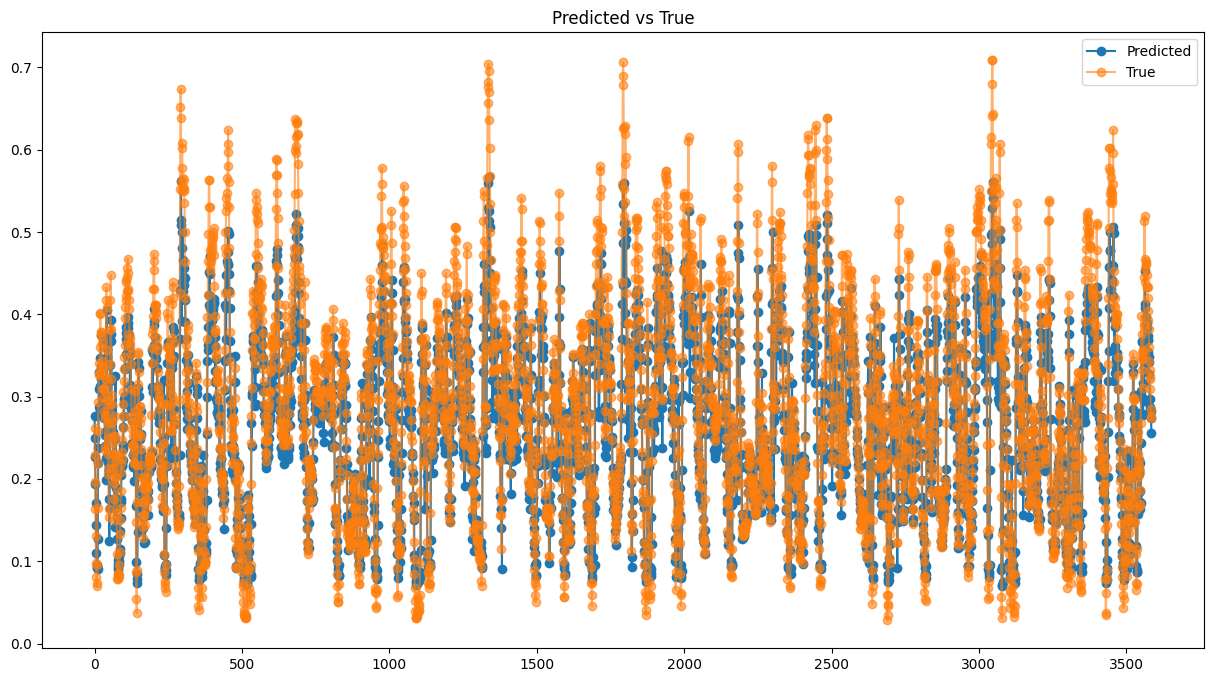

In [90]:
yhat = finetune_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [91]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.0445400359364898,
 'mse': 0.06014944828251864,
 'rmse': 0.0036179561286913847}

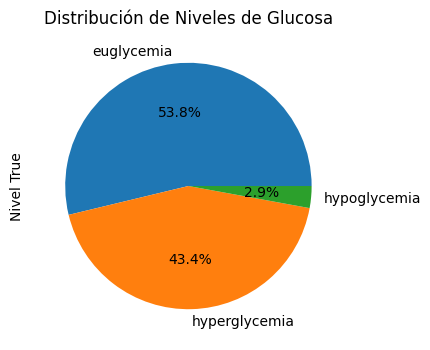

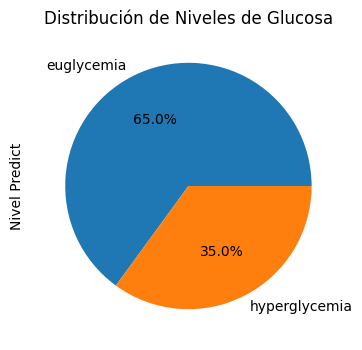

Glucose level True  Nivel True  Glucose level Predict Nivel Predict
0          160.454545  euglycemia             167.130966    euglycemia
1          145.363636  euglycemia             154.933914    euglycemia
2          130.272727  euglycemia             144.275742    euglycemia
3          115.181818  euglycemia             129.057816    euglycemia
4          100.090909  euglycemia             118.664650    euglycemia

In [92]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


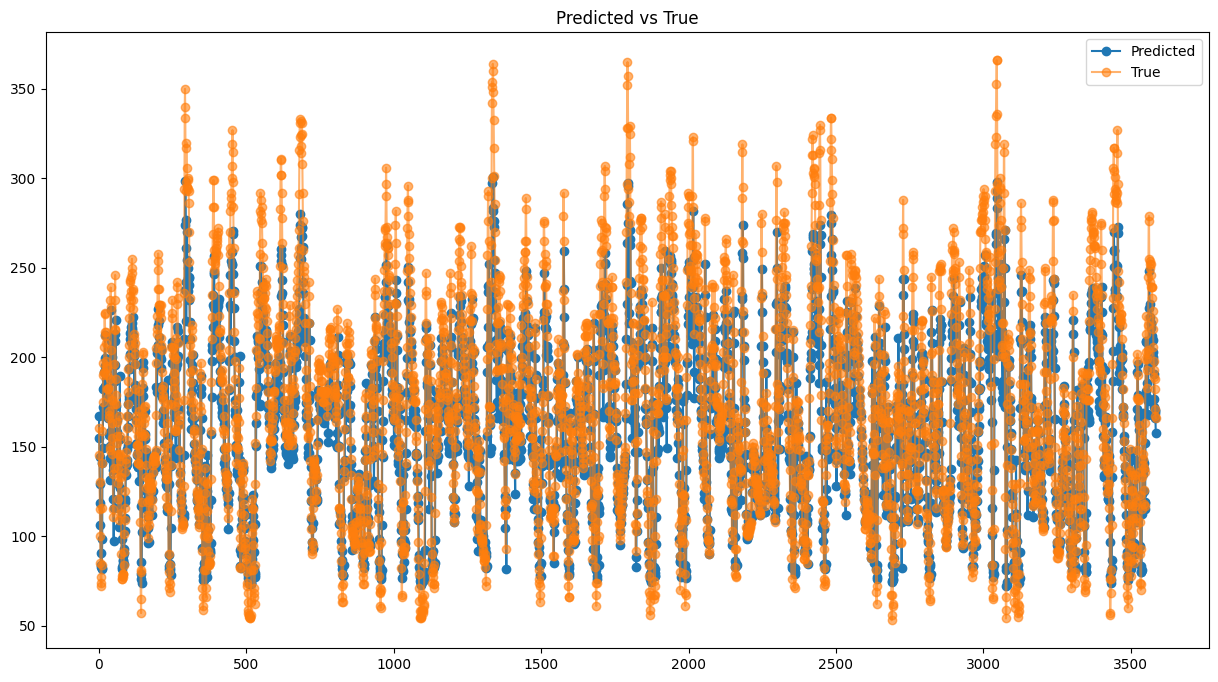

{'mae': 20.488416055427464,
 'mse': 27.668746126348392,
 'rmse': 765.5595122043192}

In [93]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [94]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=df_glucose['Glucose level True']
dfPlot['y_pred']=df_glucose['Glucose level Predict']
dfPlot.index=pd.date_range("2023-01-01", periods=len(df_glucose['Glucose level True']), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00  160.454545  167.130966
2023-01-01 00:15:00  145.363636  154.933914
2023-01-01 00:30:00  130.272727  144.275742
2023-01-01 00:45:00  115.181818  129.057816
2023-01-01 01:00:00  100.090909  118.664650
...                         ...         ...
2023-02-07 07:15:00  188.000000  170.391525
2023-02-07 07:30:00  182.000000  168.905731
2023-02-07 07:45:00  171.000000  170.062485
2023-02-07 08:00:00  167.000000  165.833755
2023-02-07 08:15:00  166.000000  157.419739

[3586 rows x 2 columns]

AP, BE, EP: (0.8747559274755927, 0.07866108786610879, 0.046582984658298465)


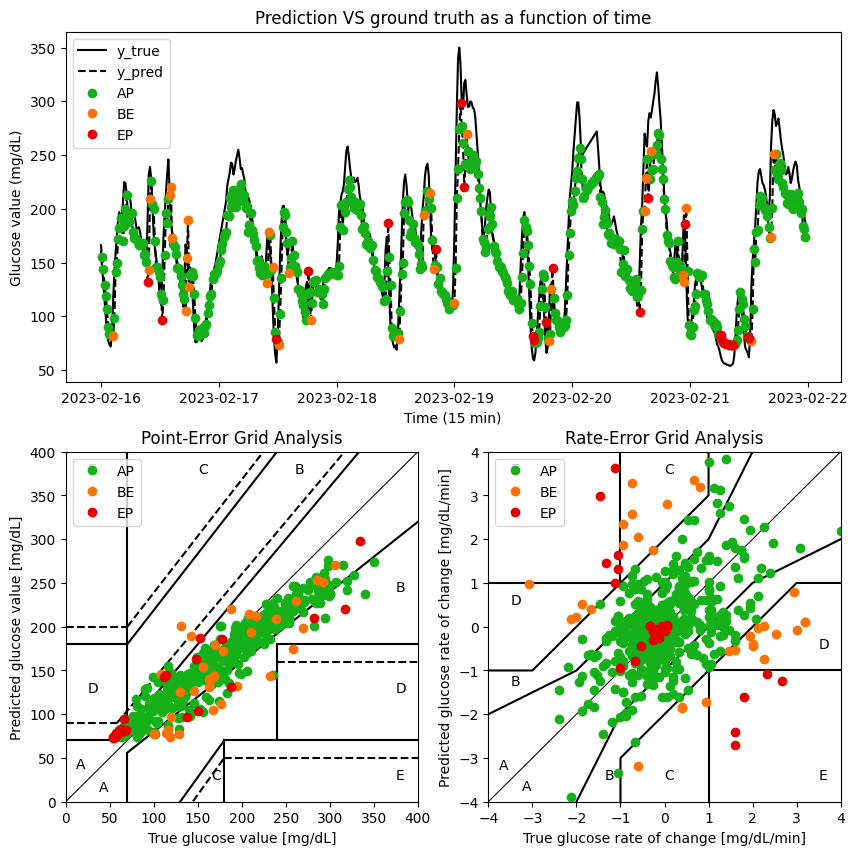

In [95]:
freq = 15
cg_ega = CG_EGA(dfPlot, freq)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

# Paciente Q4

In [96]:
paciente='paciente4'

In [97]:
with open('dataset/generado/'+paciente+'/array_Xtrain.npy', 'rb') as f:
    array_Xtrain = np.load(f)

In [98]:
len(array_Xtrain)

49606

In [99]:
with open('dataset/generado/'+paciente+'/array_Ytrain.npy', 'rb') as f:
    array_Ytrain = np.load(f)

In [100]:
len(array_Ytrain)

49606

In [101]:
with open('dataset/generado/'+paciente+'/array_Xval.npy', 'rb') as f:
    array_Xval = np.load(f)

In [102]:
len(array_Xval)

6201

In [103]:
with open('dataset/generado/'+paciente+'/array_Yval.npy', 'rb') as f:
    array_Yval = np.load(f)

In [104]:
len(array_Yval)

6201

In [105]:
with open('dataset/generado/'+paciente+'/array_Xtest.npy', 'rb') as f:
    array_Xtest = np.load(f)

In [106]:
len(array_Xtest)

6201

In [107]:
with open('dataset/generado/'+paciente+'/array_Ytest.npy', 'rb') as f:
    array_Ytest = np.load(f)

In [108]:
len(array_Ytest)

6201

In [109]:
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', patience=3, min_delta=0.001)

# Rendimiento del Modelo base

In [110]:
base_model = keras.models.load_model(modeloBasePath)

194/194 [==============================] - 1s 5ms/step


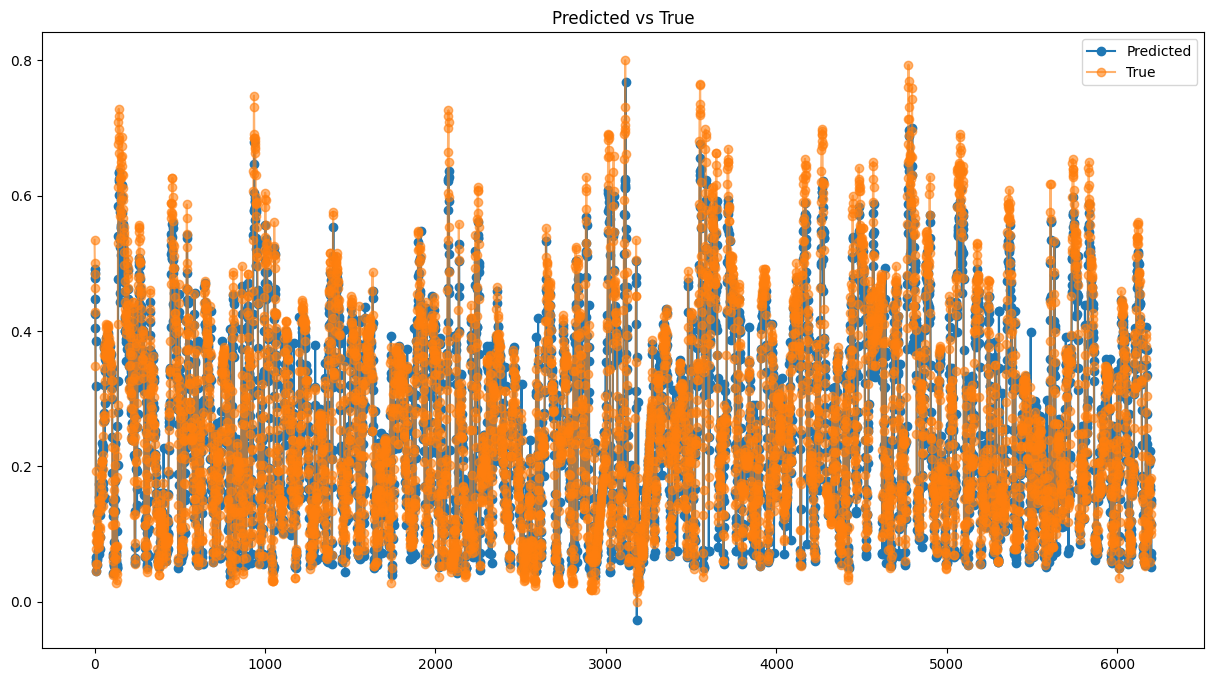

In [111]:
yhat = base_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [112]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.04068226829093997,
 'mse': 0.056452042068244924,
 'rmse': 0.0031868330536748944}

# Iniciamos transfer learning

In [113]:
# Freeze the base_model
base_model.trainable = False

In [114]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [115]:
x = base_model.layers[-2].output 

x = tf.keras.layers.Dense(16, activation='relu',name='newLayer')(x) 
predictions = tf.keras.layers.Dense(1,name='output')(x) 
    
finetune_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [116]:
base_model.layers[-2].output

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dropout_2')>

In [117]:
finetune_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 5)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0   

In [118]:
finetune_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae','mse'])

history =finetune_model.fit(array_Xtrain, array_Ytrain,epochs=epochs, validation_data=(array_Xval, array_Yval), shuffle=False, callbacks=[early_stopping])
finetune_model.save('modelos/'+paciente+modeloSave)

Epoch 1/100
1551/1551 [==============================] - 13s 8ms/step - loss: 0.0109 - mae: 0.0586 - mse: 0.0109 - val_loss: 0.0030 - val_mae: 0.0417 - val_mse: 0.0030
Epoch 2/100
1551/1551 [==============================] - 12s 8ms/step - loss: 0.0030 - mae: 0.0404 - mse: 0.0030 - val_loss: 0.0031 - val_mae: 0.0424 - val_mse: 0.0031
Epoch 3/100
1551/1551 [==============================] - 12s 8ms/step - loss: 0.0027 - mae: 0.0387 - mse: 0.0027 - val_loss: 0.0034 - val_mae: 0.0447 - val_mse: 0.0034
Epoch 4/100
1551/1551 [==============================] - 12s 8ms/step - loss: 0.0027 - mae: 0.0383 - mse: 0.0027 - val_loss: 0.0037 - val_mae: 0.0469 - val_mse: 0.0037


194/194 [==============================] - 1s 5ms/step - loss: 0.0039 - mae: 0.0465 - mse: 0.0039
test loss, test acc: [0.0038842931389808655, 0.04653133824467659, 0.0038842931389808655]


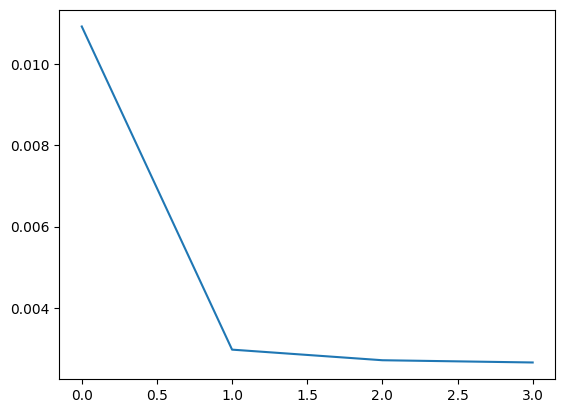

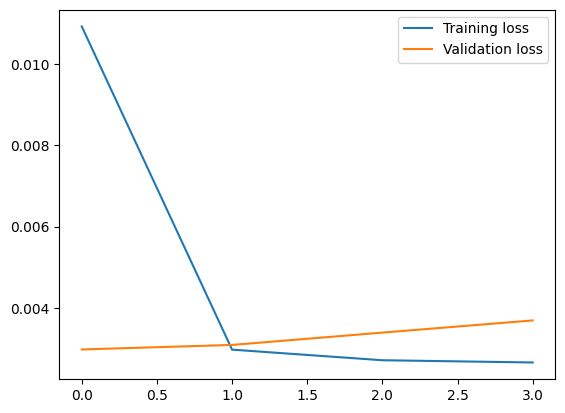

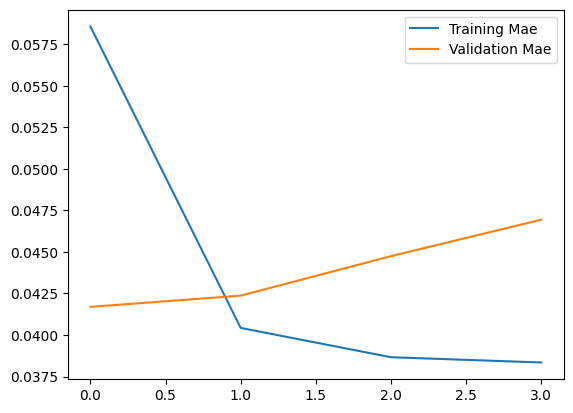

In [119]:
model_utils.modelEvaluateTraining(finetune_model,history,array_Xtest, array_Ytest)

194/194 [==============================] - 1s 5ms/step


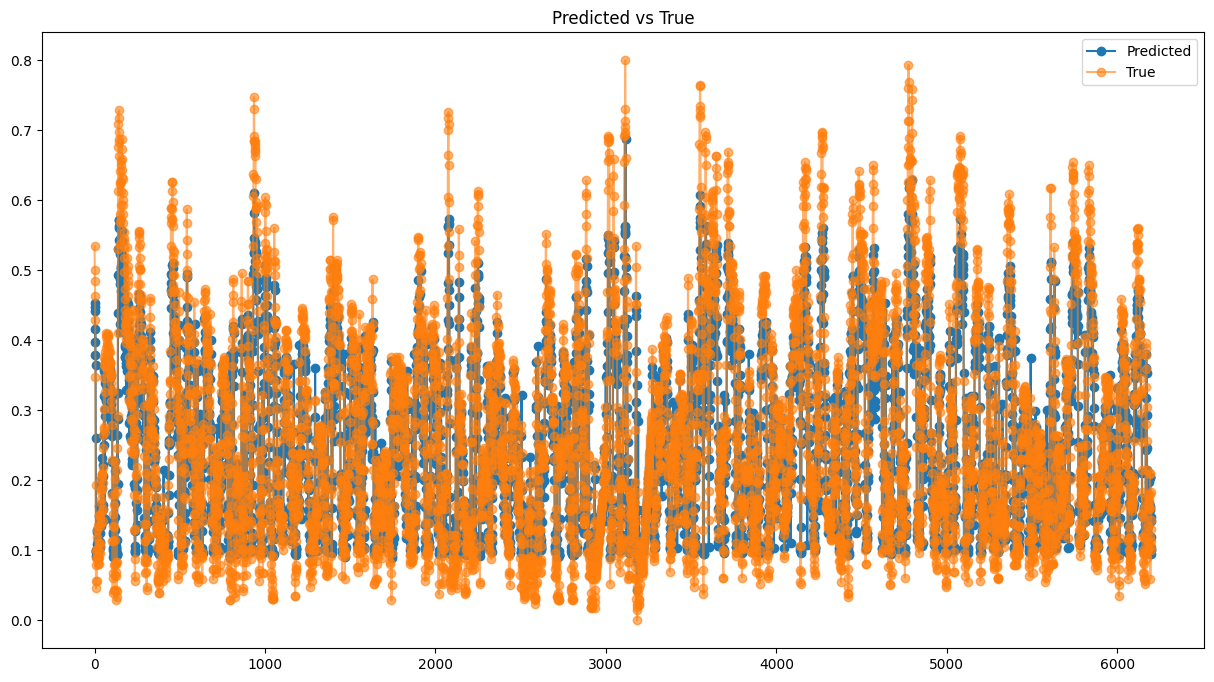

In [120]:
yhat = finetune_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [121]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.04653134112131154,
 'mse': 0.06232409412117182,
 'rmse': 0.0038842927080246833}

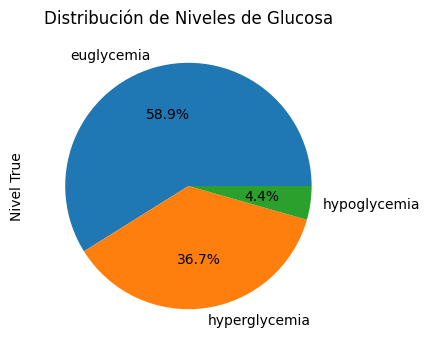

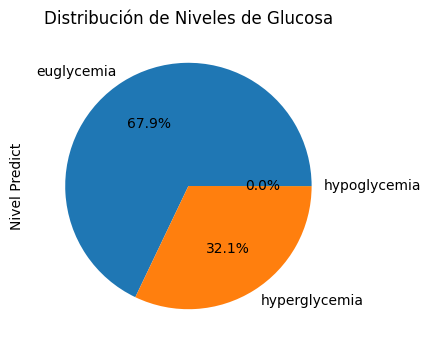

Glucose level True     Nivel True  Glucose level Predict  Nivel Predict
0               286.0  hyperglycemia             246.078705  hyperglycemia
1               270.0  hyperglycemia             248.247864  hyperglycemia
2               263.0  hyperglycemia             243.261169  hyperglycemia
3               253.0  hyperglycemia             222.786499  hyperglycemia
4               237.0  hyperglycemia             231.380798  hyperglycemia

In [122]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


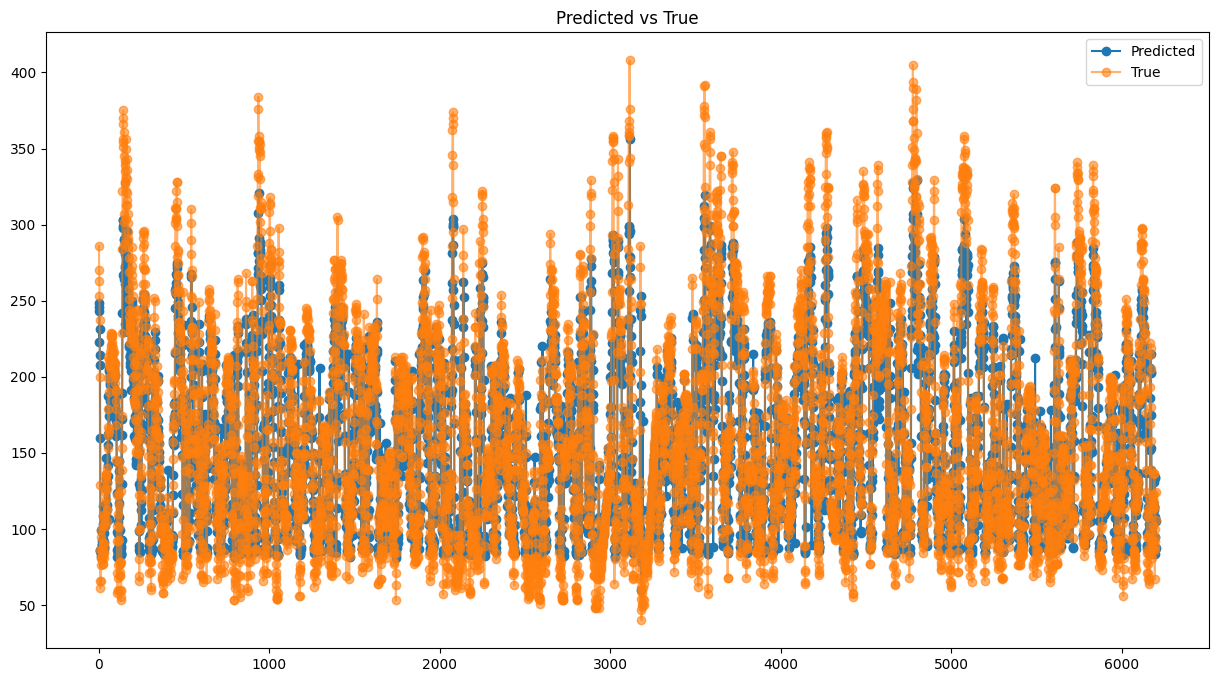

{'mae': 21.40441668666521,
 'mse': 28.669083772937324,
 'rmse': 821.9163643796982}

In [123]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [124]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=df_glucose['Glucose level True']
dfPlot['y_pred']=df_glucose['Glucose level Predict']
dfPlot.index=pd.date_range("2023-01-01", periods=len(df_glucose['Glucose level True']), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   286.0  246.078705
2023-01-01 00:15:00   270.0  248.247864
2023-01-01 00:30:00   263.0  243.261169
2023-01-01 00:45:00   253.0  222.786499
2023-01-01 01:00:00   237.0  231.380798
...                     ...         ...
2023-03-06 13:00:00   100.0   83.388718
2023-03-06 13:15:00    89.0  107.715172
2023-03-06 13:30:00    92.0   94.664345
2023-03-06 13:45:00   106.0   87.496307
2023-03-06 14:00:00   124.0  105.327538

[6201 rows x 2 columns]

AP, BE, EP: (0.8417741935483871, 0.08693548387096774, 0.07129032258064516)


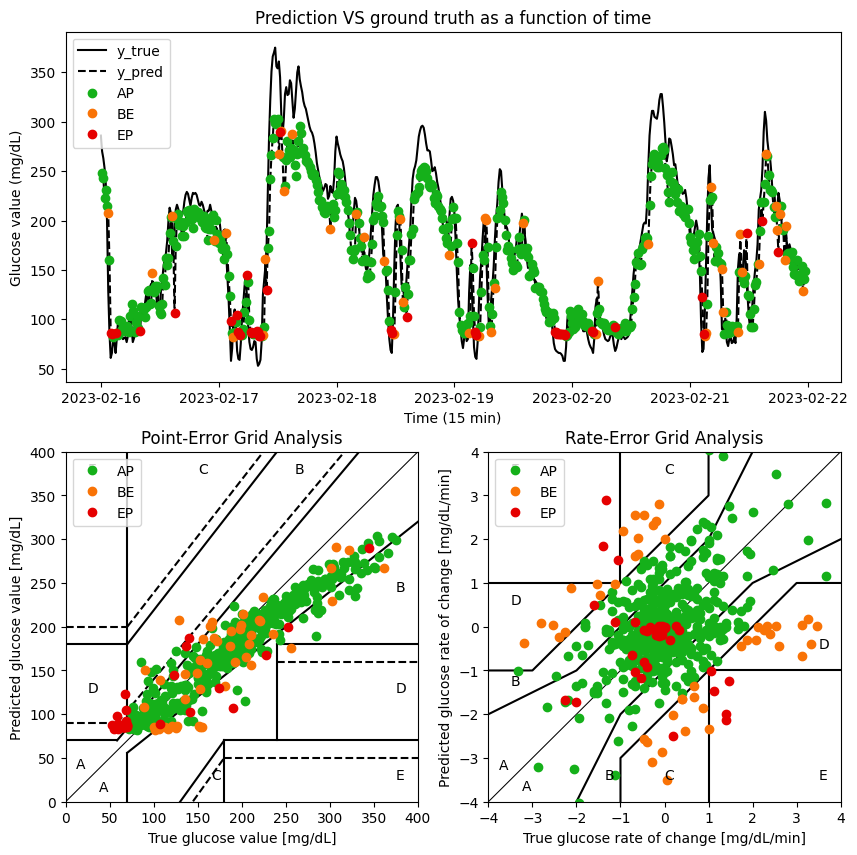

In [125]:
freq = 15
cg_ega = CG_EGA(dfPlot, freq)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)